In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
def get_cdf(values: np.ndarray):

    counts = pd.Series(values).value_counts(normalize=True)
    keys = sorted(list(counts.keys()))
    acc = 0
    cdf = []
    for key in keys:
        acc += counts[key]
        cdf.append(acc)

    return keys, cdf

def plot_cdf(keys: list, cdf: list, settings: dict, label: str):

    plt.plot(keys, cdf, label=label)
    plt.title(settings["title"])
    plt.xlabel(settings["xlabel"])
    plt.ylabel(settings["ylabel"])


def load_estimations(data_source: str, 
                     dataset: str, 
                     clf_setup: list):

    clf, proba_type, meta_features = clf_setup
    y_probs = []
    y_true = []
    for fold in np.arange(10):
        y_probs.append(np.load(f"{data_source}/local_rf/{proba_type}/{dataset}/10_folds/{clf}/{meta_features}/{fold}/test.npz")['y'])
        y_true.append(np.load(f"{data_source}/upper_bound/{proba_type}/{dataset}/10_folds/{clf}/{fold}/test.npz")['y'])
    y_probs = np.hstack(y_probs)
    y_true = np.hstack(y_true)    

    return y_probs, y_true

def compute_diffs(data_source: str, 
                  dataset: str, 
                  clf_setup: list,
                  rows: int,
                  cols: int,
                  plot_idx: int,
                  zero_keep: str,
                  label: str):

    y_probs, y_true = load_estimations(data_source, dataset, clf_setup)

    to_zero = y_probs[y_true == 0]
    zero_true = y_true[y_true == 0]
    
    to_keep = y_probs[ y_true == 1 ]
    keep_true = y_true[ y_true == 1 ]
    
    pred_zero = np.round(to_zero)
    pred_keep = np.round(to_keep)

    if zero_keep == "zero":
        title_settings = {
            "title": f"{dataset.upper()} / {clf_setup[0].upper()}\nShould Zero",
            "xlabel": "Probability Range [0.5, 1]",
            "ylabel": "(%) Docs"
        }

        diff = to_zero[pred_zero != zero_true]
        keys, cdf = get_cdf(diff)
        plt.subplot(rows, cols, plot_idx)
        plot_cdf(keys, cdf, title_settings, label)
    else:
        title_settings = {
            "title": f"{dataset.upper()} [ {clf_setup[0].upper()} / {clf_setup[1].upper()}]\nShould Keep",
            "xlabel": "Probability Range [0, 0.5]",
            "ylabel": "(%) Docs"
        }

        diff = to_keep[pred_keep != keep_true]
        keys, cdf = get_cdf(diff)
        plt.subplot(rows, cols, plot_idx)
        plot_cdf(keys, cdf, title_settings, label)

# Settings

In [13]:
CLFS_SETUP = [
    [
        [
            "bert",
            "normal_probas",
            "dist_probas_probas_based"
        ],
        [
            "bert",
            "temperature_scaling",
            "dist_probas_probas_based"
        ]
    ],
    [
        [
            "xlnet",
            "normal_probas",
            "dist_probas_probas_based"
        ],
        [
            "xlnet",
            "temperature_scaling",
            "dist_probas_probas_based"
        ]
    ],
    [
        [
            "ktmk",
            "normal_probas",
            "dist_probas_probas_based"
        ],
        [
            "ktmk",
            "isotonic",
            "dist_probas_probas_based"
        ]
    ]
]

DATA_SOURCE = "/home/welton/data/oracle"

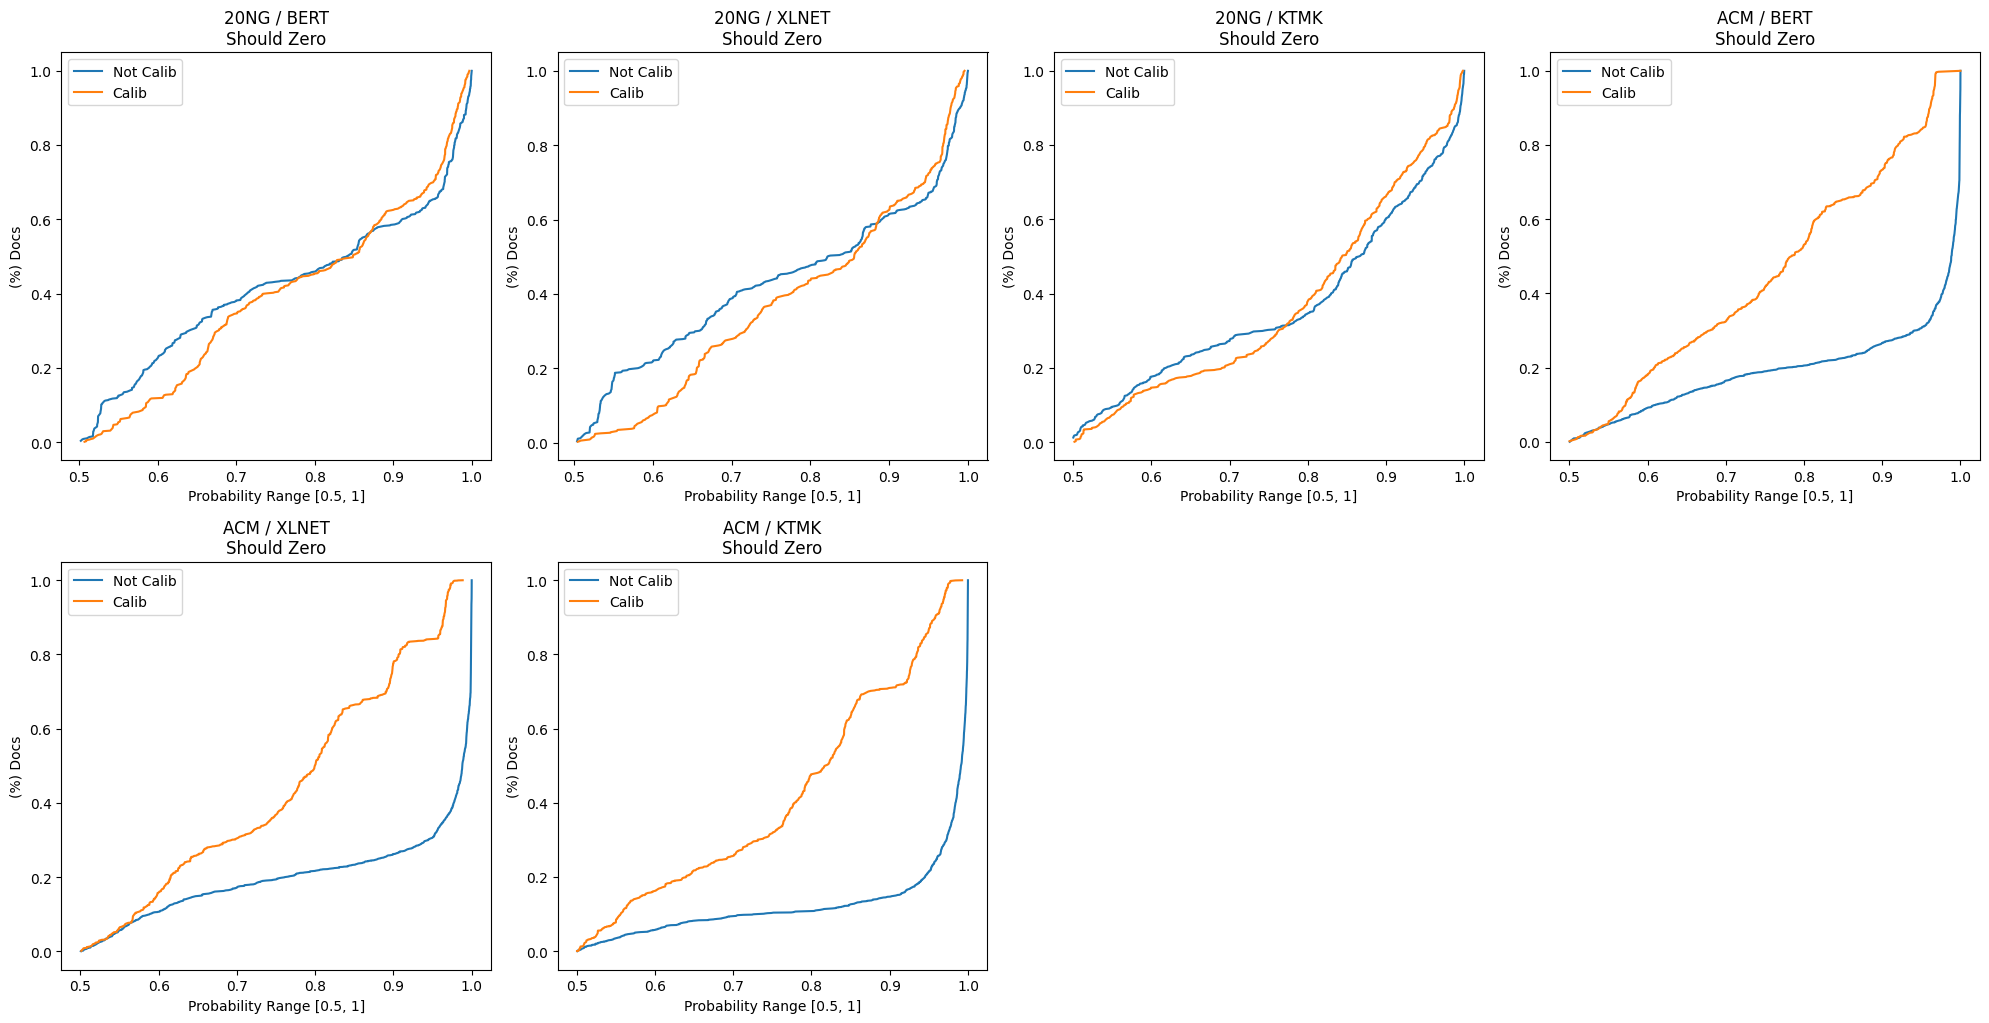

In [16]:
plt.figure(figsize=(20, 15))
plot_idx = 1
for dataset in ["20ng", "acm"]:
    for clf_setup in CLFS_SETUP:
        not_cali_setup = clf_setup[0]
        compute_diffs(DATA_SOURCE, dataset, not_cali_setup, 3, 4, plot_idx, "zero", "Not Calib")
        cali_setup = clf_setup[1]
        compute_diffs(DATA_SOURCE, dataset, cali_setup, 3, 4, plot_idx, "zero", "Calib")
        plt.legend()
        plot_idx += 1
plt.tight_layout()

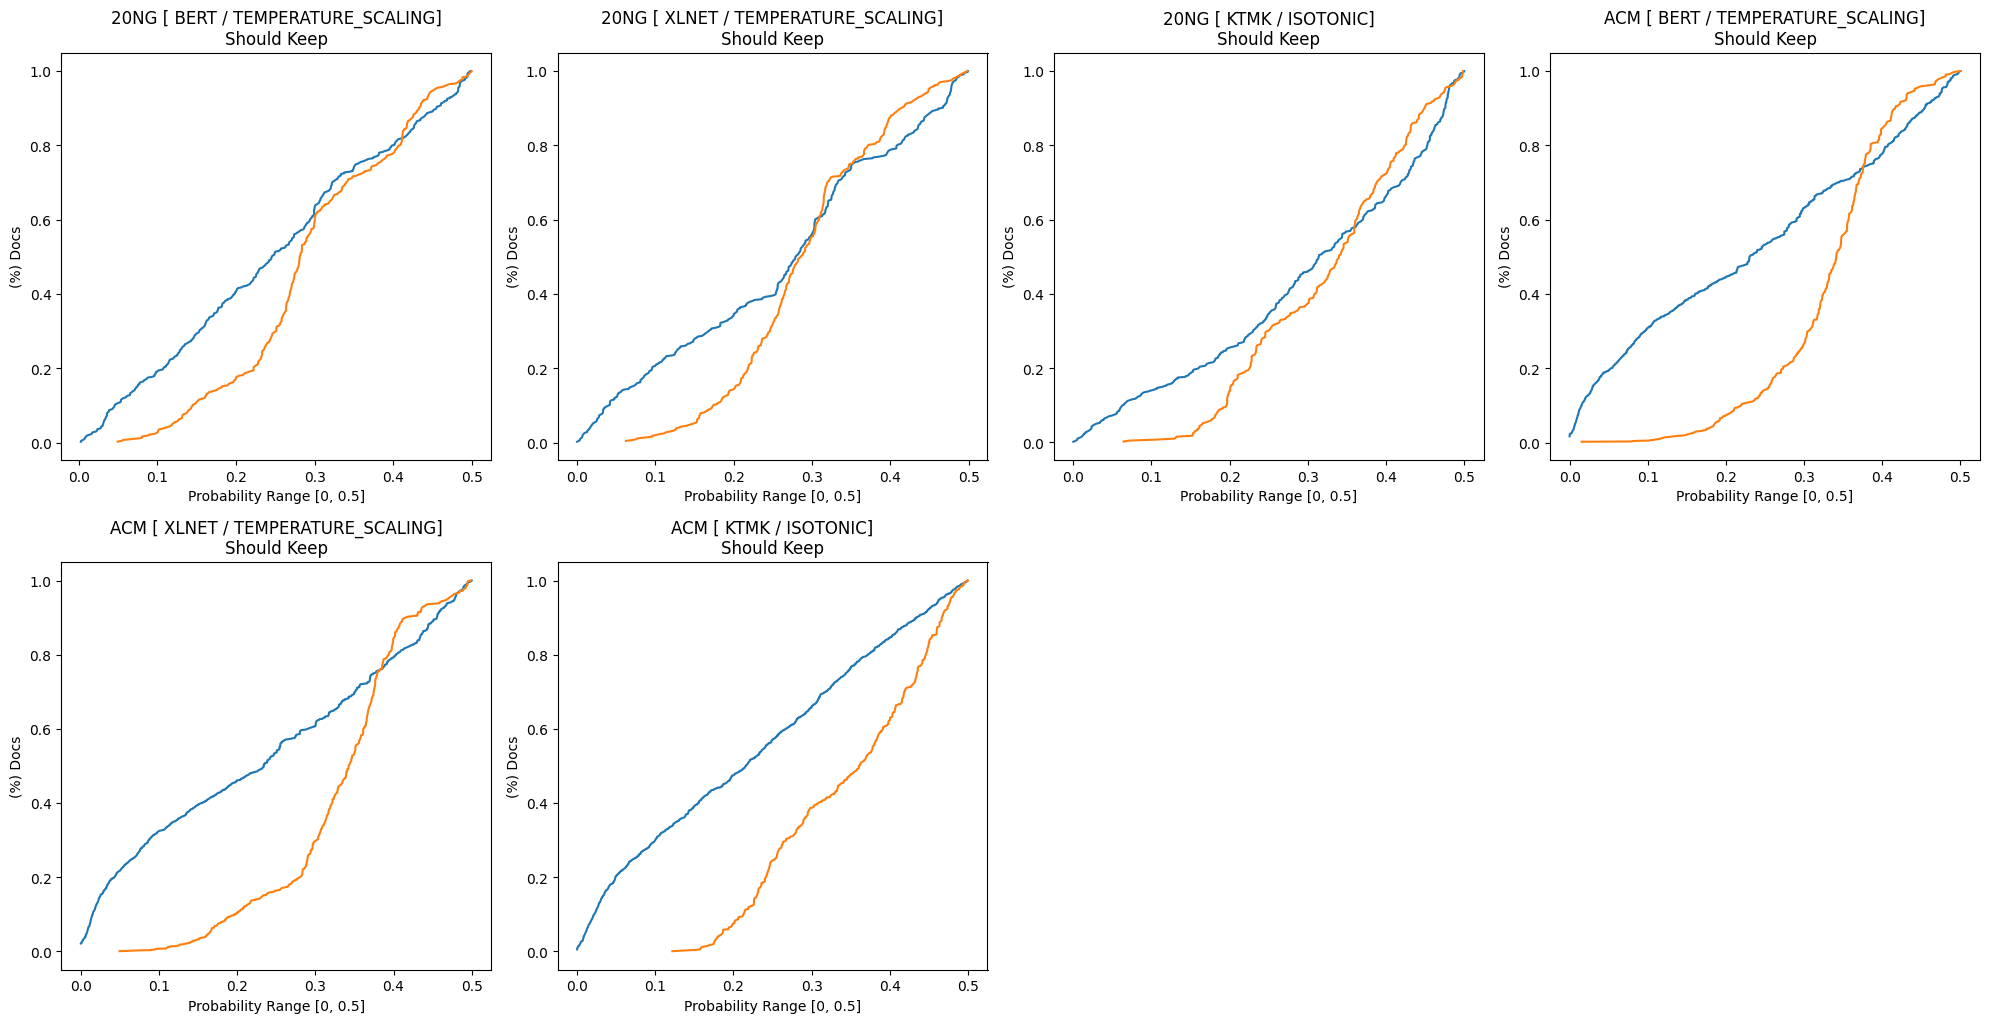

In [17]:
plt.figure(figsize=(20, 15))
plot_idx = 1
for dataset in ["20ng", "acm"]:
    for clf_setup in CLFS_SETUP:
        not_cali_setup = clf_setup[0]
        compute_diffs(DATA_SOURCE, dataset, not_cali_setup, 3, 4, plot_idx, "keep", "Not Calib")
        cali_setup = clf_setup[1]
        compute_diffs(DATA_SOURCE, dataset, cali_setup, 3, 4, plot_idx, "keep", "Calib")
        plot_idx += 1

plt.tight_layout()